In [1]:
cbis_path = 'C:/Users/CHRISTIANAH/Documents/Aaaa/DS/CBIS_DDSM'

In [3]:
# Import libraries

#%tensorflow_version 1.x
import os
import numpy as np
import cv2
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [4]:
def load_testing():
    """
    Load test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images,labels

def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("Unrecognized label (%d)" % l)
        return None

# Load test images
test_images, test_labels= load_testing()
test_images_vgg, _ = load_testing()

# Remap test labels
test_labels = np.array([remap_label(l) for l in test_labels])

# Number of images
n_test_img = test_images.shape[0]

# Compute width and height of images
img_w = test_images.shape[1]
img_h = test_images.shape[2]

# Create a new dimension for color in the images arrays
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))
test_images_vgg = test_images_vgg.reshape((n_test_img, img_w, img_h, 1))

# Rescale values to (0-1), or (0-255) for VGG
test_images = test_images.astype('uint16') / 65535
test_images_vgg = test_images_vgg.astype('uint16') / 256

# Replicate the only channel 3 times for VGG16
test_images_vgg = np.repeat(test_images_vgg, 3, axis=3)

# Normalize VGG images
preprocess_input(test_images_vgg);

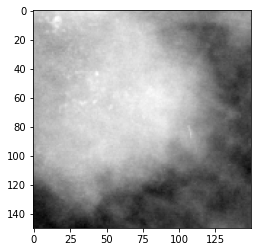

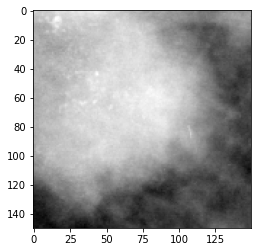

In [5]:
# Make sure images are still ok

idx = 0

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.figure()

plt.imshow(test_images_vgg[idx][:,:,0]/256, cmap='gray')
plt.show()

In [12]:
model_dir = 'C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/'

model3 = models.load_model(os.path.join(model_dir, 'model_3_2cl_best.h5'))
model4 = models.load_model(os.path.join(model_dir, 'model_4_2cl_best.h5'))
model9 = models.load_model(os.path.join(model_dir, 'model_9_2cl_best.h5'))
modelvgg = models.load_model(os.path.join(model_dir, 'vgg16_ft_2layer_2cl_best.h5'))

In [13]:
_, acc3 = model3.evaluate(test_images, test_labels, verbose=False)
_, acc4 = model4.evaluate(test_images, test_labels, verbose=False)
_, acc9 = model9.evaluate(test_images, test_labels, verbose=False)
_, accvgg = modelvgg.evaluate(test_images_vgg, test_labels, verbose=False)

## Ensemble 1

Three models: M3, M4 and M9

In [14]:
# Get class predictions
ensemble1_cl = np.array([
    np.argmax(model3.predict(test_images), axis=-1).tolist(),
    np.argmax(model4.predict(test_images), axis=-1).tolist(),
    np.argmax(model9.predict(test_images), axis=-1).tolist()
])

# Get prediction probabilities
ensemble1_pred = np.array([
    model3.predict(test_images).tolist(),
    model4.predict(test_images).tolist(),
    model9.predict(test_images).tolist()
])

In [16]:
import numpy as np
import statistics

# Accuracy by voting
ensemble1_voting_pred = np.array([statistics.mode([ensemble1_cl[m][e] for m in range(len(ensemble1_cl))]) for e in range(n_test_img)])
ensemble1_voting_right = sum([p == l for p, l in zip(ensemble1_voting_pred, test_labels)])
ensemble1_voting_acc = ensemble1_voting_right / n_test_img

# Accuracy by averaging
ensemble1_avg_pred = np.array([np.mean([ensemble1_pred[m][e] for m in range(len(ensemble1_pred))]) for e in range(n_test_img)])
ensemble1_avg_right = sum([(abs(p - l) < 0.5) for p, l in zip(ensemble1_avg_pred, test_labels)])
ensemble1_avg_acc = ensemble1_avg_right / n_test_img

print("\nM3")
print(ensemble1_cl[0])
print("Acc: %.4f" % acc3)
print("\nM4")
print(ensemble1_cl[1])
print("Acc: %.4f" % acc4)
print("\nM9")
print(ensemble1_cl[2])
print("Acc: %.4f" % acc9)
print("\nEnsemble")
print(ensemble1_voting_pred)

print("Voting accuracy: %.4f" % ensemble1_voting_acc)
print("Averaging accuracy: %.4f" % ensemble1_avg_acc)


M3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Acc: 0.8750

M4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Ensemble 2

In [17]:
# Get class predictions using np.argmax for multi-class predictions
ensemble2_cl = np.array([
    np.argmax(model3.predict(test_images), axis=-1).tolist(), 
    np.argmax(model4.predict(test_images), axis=-1).tolist(), 
    np.argmax(model9.predict(test_images), axis=-1).tolist(),
    np.argmax(modelvgg.predict(test_images_vgg), axis=-1).tolist()
])

# Get prediction probabilities
ensemble2_pred = np.array([
    model3.predict(test_images).tolist(), 
    model4.predict(test_images).tolist(), 
    model9.predict(test_images).tolist(),
    modelvgg.predict(test_images_vgg).tolist()
])


In [18]:
import numpy as np
import statistics

# Accuracy by voting
ensemble2_voting_pred = np.array([statistics.mode([ensemble2_cl[m][e] for m in range(len(ensemble2_cl))]) for e in range(n_test_img)])
ensemble2_voting_right = sum([p == l for p, l in zip(ensemble2_voting_pred, test_labels)])
ensemble2_voting_acc = ensemble2_voting_right / n_test_img

# Accuracy by averaging
ensemble2_avg_pred = np.array([np.mean([ensemble2_pred[m][e] for m in range(len(ensemble2_pred))]) for e in range(n_test_img)])
ensemble2_avg_right = sum([(abs(p - l) < 0.5) for p, l in zip(ensemble2_avg_pred, test_labels)])
ensemble2_avg_acc = ensemble2_avg_right / n_test_img

print("\nM3")
print(ensemble2_cl[0])
print("Acc: %.4f" % acc3)

print("\nM4")
print(ensemble2_cl[1])
print("Acc: %.4f" % acc4)

print("\nM9")
print(ensemble2_cl[2])
print("Acc: %.4f" % acc9)

print("\nVGG")
print(ensemble2_cl[3])
print("Acc: %.4f" % accvgg)

print("\nEnsemble")
print(ensemble2_voting_pred)

print("Voting accuracy: %.4f" % ensemble2_voting_acc)
print("Averaging accuracy: %.4f" % ensemble2_avg_acc)



M3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Acc: 0.8750

M4
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

CLASSIFICATION REPORT

In [19]:
from sklearn.metrics import classification_report

# Predictions for model3
preds3 = model3.predict(test_images)
preds3 = (preds3 > 0.5).astype(int)  # Convert probabilities to binary predictions

# Predictions for model4
preds4 = model4.predict(test_images)
preds4 = (preds4 > 0.5).astype(int)  # Convert probabilities to binary predictions

# Predictions for model9
preds9 = model9.predict(test_images)
preds9 = (preds9 > 0.5).astype(int)  # Convert probabilities to binary predictions

# Classification report for model3
print("Classification Report for Model 3:")
print(classification_report(test_labels, preds3))

# Classification report for model4
print("Classification Report for Model 4:")
print(classification_report(test_labels, preds4))

# Classification report for model9
print("Classification Report for Model 9:")
print(classification_report(test_labels, preds9))

Classification Report for Model 3:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       179
           1       0.85      0.89      0.87       157

    accuracy                           0.88       336
   macro avg       0.87      0.88      0.87       336
weighted avg       0.88      0.88      0.88       336

Classification Report for Model 4:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       179
           1       0.89      0.83      0.86       157

    accuracy                           0.87       336
   macro avg       0.87      0.87      0.87       336
weighted avg       0.87      0.87      0.87       336

Classification Report for Model 9:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       179
           1       0.87      0.82      0.85       157

    accuracy                           0.86       336
   macro avg       0.86

In [20]:
# Predictions for modelvgg
predsvgg = modelvgg.predict(test_images_vgg)
predsvgg = (predsvgg > 0.5).astype(int)  # Convert probabilities to binary predictions

# Classification report for modelvgg
print("Classification Report for VGG16:")
print(classification_report(test_labels, predsvgg))

Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       179
           1       0.91      0.81      0.86       157

    accuracy                           0.87       336
   macro avg       0.88      0.87      0.87       336
weighted avg       0.88      0.87      0.87       336



ALL THE MODELS TOGETHER

In [22]:
import pandas as pd

# Define the data
data = {
    'Model': ['M3', 'M4', 'M9', 'VGG', 'Ensemble1 (Voting)', 'Ensemble1 (Averaging)', 'Ensemble2 (Voting)', 'Ensemble2 (Averaging)'],
    'Accuracy': [acc3, acc4, acc9, accvgg, ensemble1_voting_acc, ensemble1_avg_acc, ensemble2_voting_acc, ensemble2_avg_acc]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame (optional)
print(df)

# Define the path to save the CSV file
csv_file_path = 'C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/accuracies.csv'

# Save the DataFrame to CSV
df.to_csv(csv_file_path, index=False)

print(f"Accuracies saved successfully to {csv_file_path}")


                   Model  Accuracy
0                     M3  0.875000
1                     M4  0.872024
2                     M9  0.860119
3                    VGG  0.872024
4     Ensemble1 (Voting)  0.532738
5  Ensemble1 (Averaging)  0.875000
6     Ensemble2 (Voting)  0.532738
7  Ensemble2 (Averaging)  0.883929
Accuracies saved successfully to C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/accuracies.csv


In [24]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = 'C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/accuracies.csv'

# Load the CSV file into a DataFrame
df_loaded = pd.read_csv(csv_file_path)

# Print the loaded DataFrame (optional)
df_loaded

,Model,Accuracy
0,M3,0.875000
1,M4,0.872024
2,M9,0.860119
3,VGG,0.872024
4,Ensemble1 (Voting),0.532738
5,Ensemble1 (Averaging),0.875000
6,Ensemble2 (Voting),0.532738
7,Ensemble2 (Averaging),0.883929


In [30]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = 'C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/accuracies.csv'

# Load the CSV file into a DataFrame
df_loaded = pd.read_csv(csv_file_path)

# Sort the DataFrame by the "Accuracy" column in descending order
df_sorted = df_loaded.sort_values(by="Accuracy", ascending=False)

# Print the sorted DataFrame
print(df_sorted)

# Optionally, save the sorted DataFrame back to a CSV file
sorted_csv_file_path = 'C:/Users/CHRISTIANAH/Documents/Aaaa/DS/models/accuracies_sorted.csv'
df_sorted.to_csv(sorted_csv_file_path, index=False)


                   Model  Accuracy
7  Ensemble2 (Averaging)  0.883929
0                     M3  0.875000
5  Ensemble1 (Averaging)  0.875000
1                     M4  0.872024
3                    VGG  0.872024
2                     M9  0.860119
4     Ensemble1 (Voting)  0.532738
6     Ensemble2 (Voting)  0.532738


In [33]:
from scipy.stats import ttest_rel

# Example accuracies from multiple test runs
best_two_cnn_models_acc = [0.8750, 0.8720]
ensemble_acc = [0.8750, 0.8839]

# Perform paired t-test
t_stat, p_value = ttest_rel(best_two_cnn_models_acc, ensemble_acc)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Check if p-value is less than 0.05 to reject the null hypothesis
if p_value < 0.05:
    print("Reject the null hypothesis: Fine-tuning significantly improves accuracy.")
else:
    print("Fail to reject the null hypothesis: Fine-tuning does not significantly improve accuracy.")




T-statistic: -1.0, P-value: 0.49999999999999956
Fail to reject the null hypothesis: Fine-tuning does not significantly improve accuracy.
